In [1]:
from skimage.io import imread

image_file = r"D:\Histology images\Images\ytma23_022103_benign1_ccd.tif"

image = imread(image_file)

print(f'Loaded image in an array of shape: {image.shape} and data type {image.dtype}')
print(f'Intensity range: [{image.min()} - {image.max()}]')

Loaded image in an array of shape: (768, 896, 3) and data type uint8
Intensity range: [20 - 255]


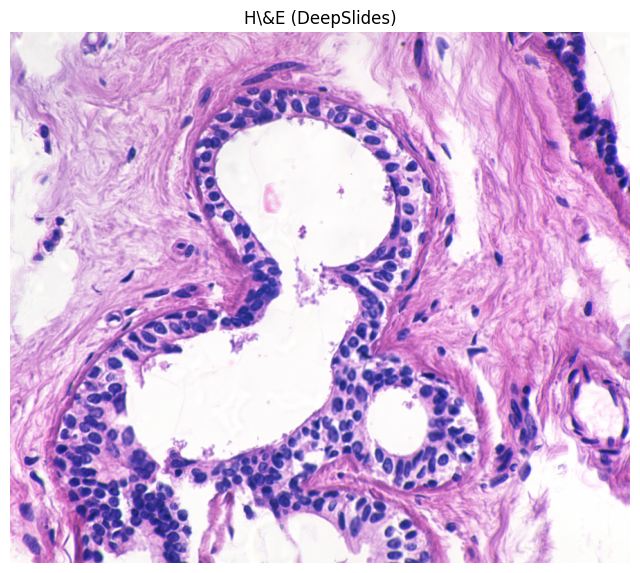

In [2]:
import matplotlib.pyplot as plt

fig_mpl, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, cmap='gray')
plt.title(r"H\&E (DeepSlides)")  # Use raw string to escape `&`
plt.axis('off')
plt.show()

In [3]:
from skimage.exposure import rescale_intensity

image_normed = rescale_intensity(image, out_range=(0, 1))

print(f'Intensity range: [{image_normed.min()} - {image_normed.max()}]')
print(f'Array type: {image_normed.dtype}')

Intensity range: [0.0 - 1.0]
Array type: float64


In [4]:
from stardist.models import StarDist2D
model = StarDist2D.from_pretrained("2D_versatile_he")

model

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[512, 512], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.1], train_class_weights=(1, 1), train_epochs=200, train_steps_per_epoch=200, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=3, train_tensorboard=True, train_r

In [5]:
labels, polys = model.predict_instances(
    image_normed,  # The image must be normalized
    axes="YXC",
    prob_thresh=0.5,  # Detection probability threshold
    nms_thresh=0.1,  # Remove detections overlapping by more than this threshold
    scale=1,  # Higher values are suitable for lower resolution data
    return_labels=True,
)

# We also get detection probabilities
probabilities = list(polys["prob"])

n_detections = len(probabilities)

print(f'{n_detections} cells detected.')

377 cells detected.


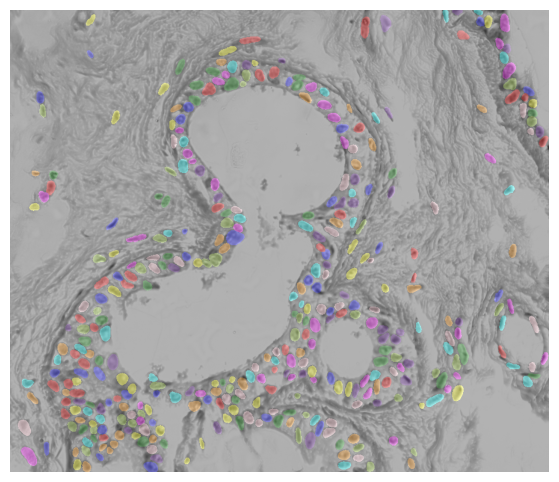

In [6]:
from skimage.color import label2rgb

fig, ax = plt.subplots(figsize=(12, 6))
rgb_composite = label2rgb(labels, image=image, bg_label=0)
ax.imshow(rgb_composite)
plt.axis('off')
plt.show()

In [7]:
from PIL import Image, ImageOps
import numpy as np

probabilities.insert(0, 0)

parametric_image = np.take(probabilities, labels)

image_ = Image.fromarray(image).convert("RGBA")

mask = Image.fromarray((labels == 0).astype('uint8')).convert("L")

alpha_mask = mask.point(lambda p: 128 if p == 0 else 0)

colorized_mask = ImageOps.colorize(
    Image.fromarray((parametric_image * 255).astype(np.uint8)).convert("L"), 
    black="green", 
    white="yellow", 
    blackpoint=128,
    whitepoint=255,
).convert("RGBA")

colorized_mask.putalpha(alpha_mask)

composite_image = Image.alpha_composite(image_, colorized_mask)

Loaded image in an array of shape: (768, 896, 3) and data type uint8
Intensity range: [20 - 255]
Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


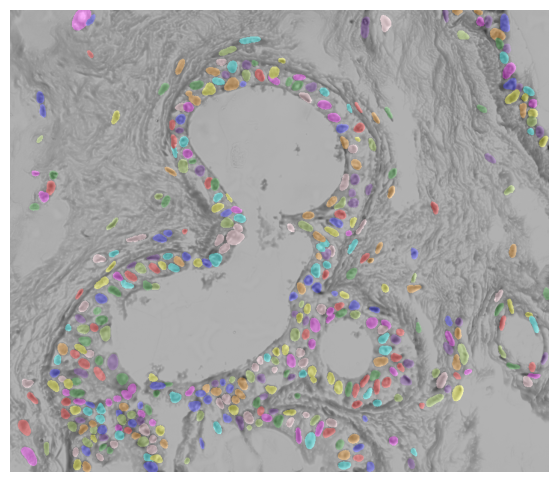

Coordinates and radii of cells saved to D:\Histology images\cell_coordinates.csv


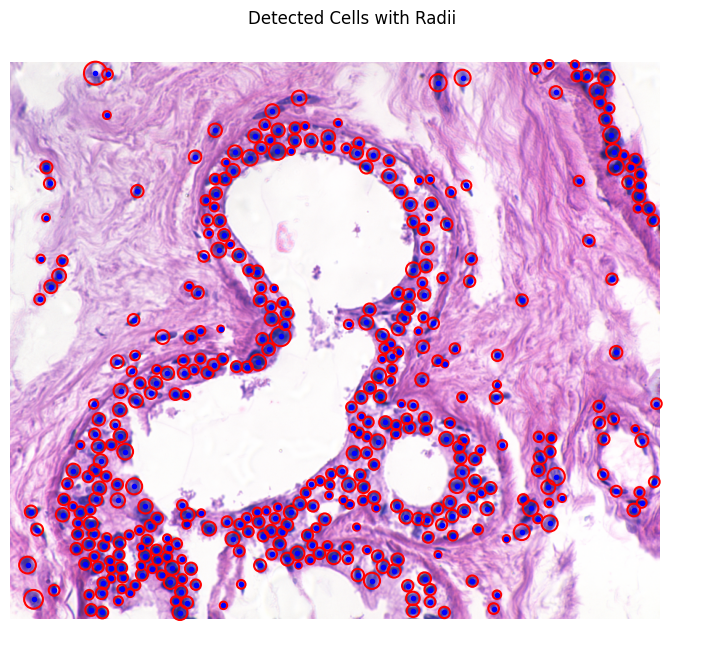

In [8]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.color import label2rgb
import matplotlib.pyplot as plt
from stardist.models import StarDist2D
import pandas as pd
import numpy as np
import cv2

# Load the image
image_file = r"D:\Histology images\Images\ytma23_022103_benign1_ccd.tif"
image = imread(image_file)

print(f'Loaded image in an array of shape: {image.shape} and data type {image.dtype}')
print(f'Intensity range: [{image.min()} - {image.max()}]')

# Normalize the image for StarDist
image_normed = (image - image.min()) / (image.max() - image.min())

# Load the StarDist2D model
model = StarDist2D.from_pretrained("2D_versatile_he")

# Perform cell detection and segmentation
labels, polys = model.predict_instances(
    image_normed,
    axes="YXC",
    prob_thresh=0.3,  # Lower probability threshold for more detection
    nms_thresh=0.3,   # Adjust overlap threshold
    scale=1.0,        # Scale adjustment for resolution
    return_labels=True,
)



# Visualize the detected cells with their labels
def visualize_labels_on_image(image, labels):
    fig, ax = plt.subplots(figsize=(12, 6))
    rgb_composite = label2rgb(labels, image=image, bg_label=0)
    ax.imshow(rgb_composite)
    plt.axis('off')
    plt.show()

visualize_labels_on_image(image, labels)

# Extract properties of each detected cell
props = regionprops(labels)
cell_data = []

for prop in props:
    y, x = prop.centroid  # Cell center (Y, X)
    radius = (prop.equivalent_diameter / 2)  # Radius assuming circular shape
    cell_data.append((x, y, radius))

# Save cell data to CSV
cell_df = pd.DataFrame(cell_data, columns=["X_Center", "Y_Center", "Radius"])
output_csv_path = r"D:\Histology images\cell_coordinates.csv"
cell_df.to_csv(output_csv_path, index=False)

print(f"Coordinates and radii of cells saved to {output_csv_path}")

# Visualize cell centers and radii on the image
def plot_cells_with_radii(image, cell_data):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image, cmap='gray')
    for x, y, radius in cell_data:
        circ = plt.Circle((x, y), radius, color='red', fill=False, linewidth=1.5)
        ax.add_patch(circ)
        ax.plot(x, y, 'bo', markersize=3)  # Mark the center with a blue dot
    plt.title("Detected Cells with Radii")
    plt.axis('off')
    plt.show()

plot_cells_with_radii(image, cell_data)


In [9]:
props = regionprops(labels)
point_cloud = np.array([[prop.centroid[1], prop.centroid[0]] for prop in props])  # (X, Y) format

# Print the shape of the extracted point cloud
print(f"Extracted point cloud with shape: {point_cloud.shape}")

# Save to CSV (optional)
output_csv_path = r"D:\Histology images\cell_point_cloud.csv"
pd.DataFrame(point_cloud, columns=["X_Center", "Y_Center"]).to_csv(output_csv_path, index=False)

Extracted point cloud with shape: (413, 2)


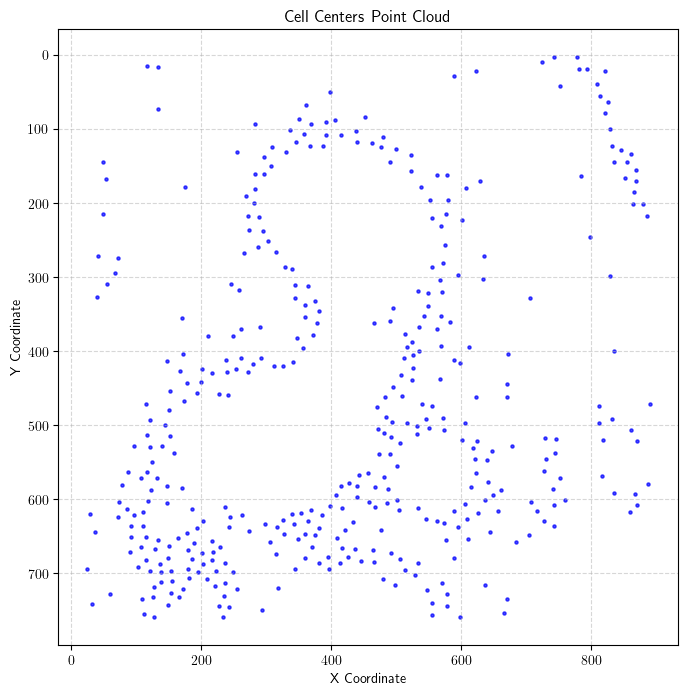

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cell data (X and Y coordinates)
file_path = r"D:\Histology images\cell_point_cloud.csv"
cell_df = pd.read_csv(file_path)

# Plot the cell centers as a point cloud
plt.figure(figsize=(8, 8))
plt.scatter(cell_df["X_Center"], cell_df["Y_Center"], c='blue', s=5, alpha=0.7)
plt.title("Cell Centers Point Cloud")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [29]:
point_cloud = cell_df[["X_Center", "Y_Center"]].to_numpy()

downsampled_cloud = point_cloud[np.random.choice(point_cloud.shape[0], 200, replace=False)]

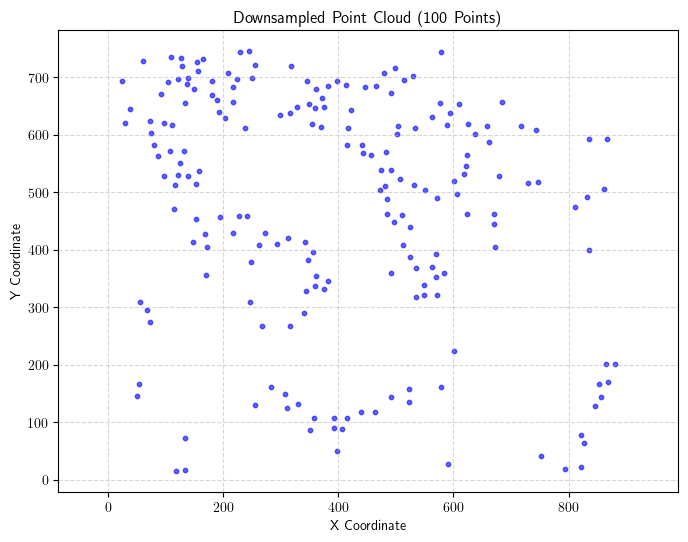

In [30]:
import matplotlib.pyplot as plt

# Scatter plot of the downsampled point cloud
plt.figure(figsize=(8, 6))
plt.scatter(downsampled_cloud[:, 0], downsampled_cloud[:, 1], color='blue', s=10, alpha=0.6)

# Formatting
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Downsampled Point Cloud (100 Points)")
plt.axis("equal")  # Keep aspect ratio equal
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()


# Spectral Sequence

In [35]:
from permaviss.spectral_sequence.MV_spectral_seq import create_MV_ss
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

max_r = 50
max_dim = 2  
max_div = 3
overlap = max_r*1.01
p = 3

MV_ss = create_MV_ss(downsampled_cloud, max_r, max_dim, max_div, overlap, p)

PAGE: 1
[[ 15   0   0   0   0]
 [251  54   4   1   0]]
PAGE: 2
[[ 15   0   0   0   0]
 [200   1   0   0   0]]
PAGE: 3
[[ 15   0   0   0   0]
 [200   1   0   0   0]]


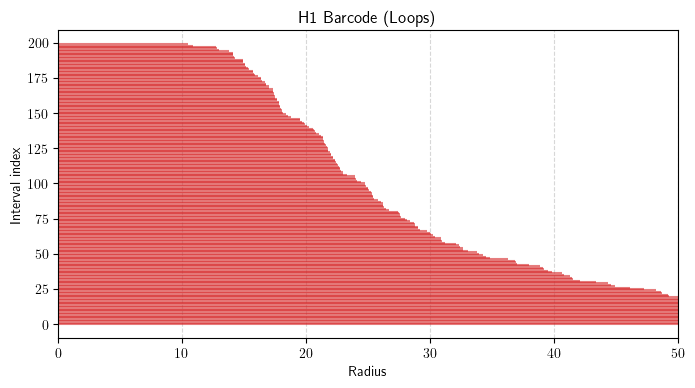

In [36]:
h1_intervals = MV_ss.persistent_homology[0].barcode

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("H1 Barcode (Loops)")
for idx, (birth, death) in enumerate(h1_intervals):
    ax.hlines(y=idx, xmin=birth, xmax=death if death != np.inf else max_r, color='tab:red', alpha=0.6, linewidth=1.5)

ax.set_xlabel("Radius")
ax.set_ylabel("Interval index")
ax.set_xlim(0, max_r)
ax.grid(axis='x', linestyle='--', alpha=0.5)
plt.show() 

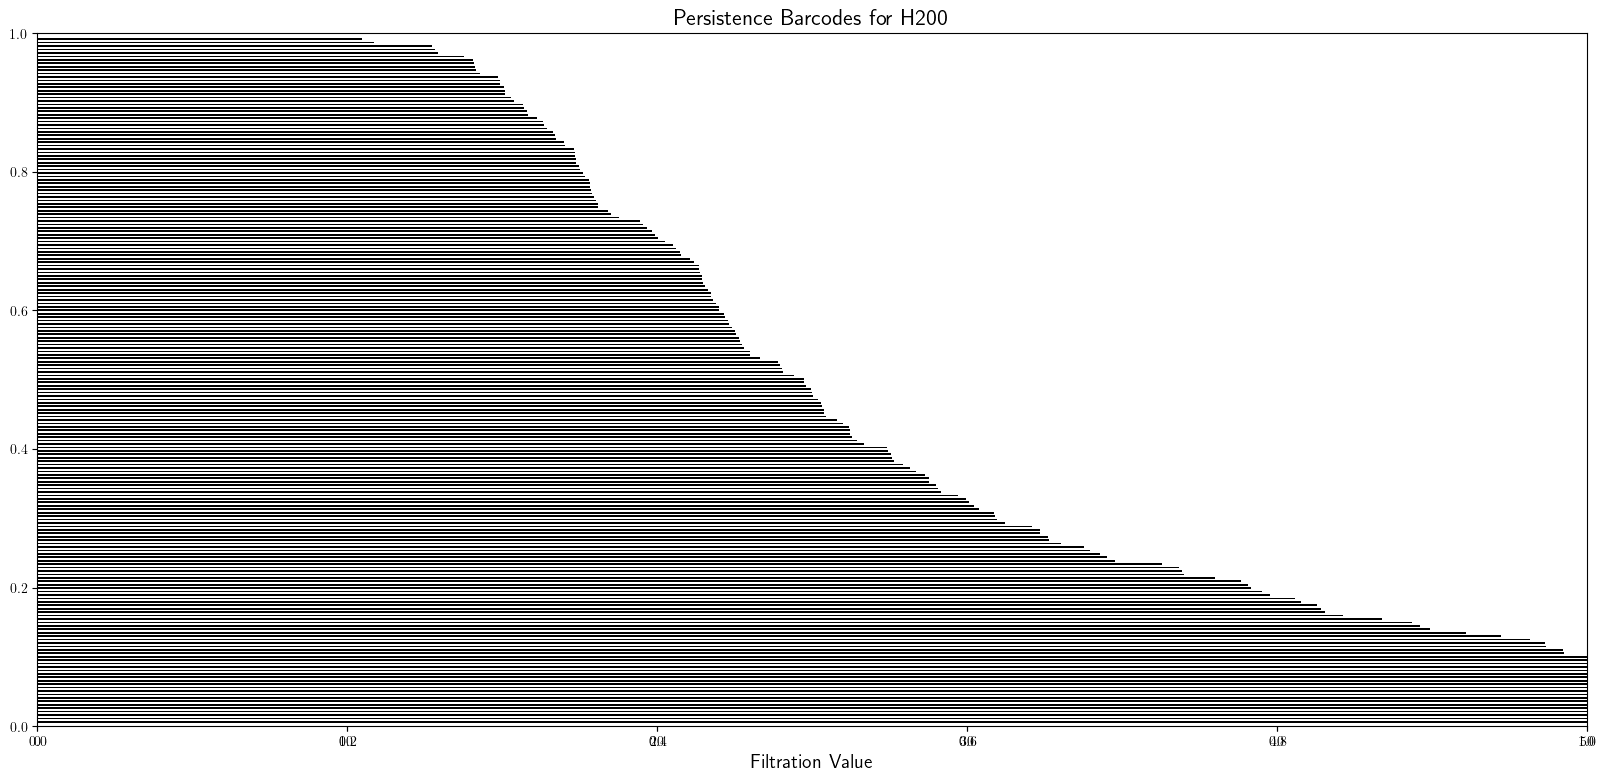

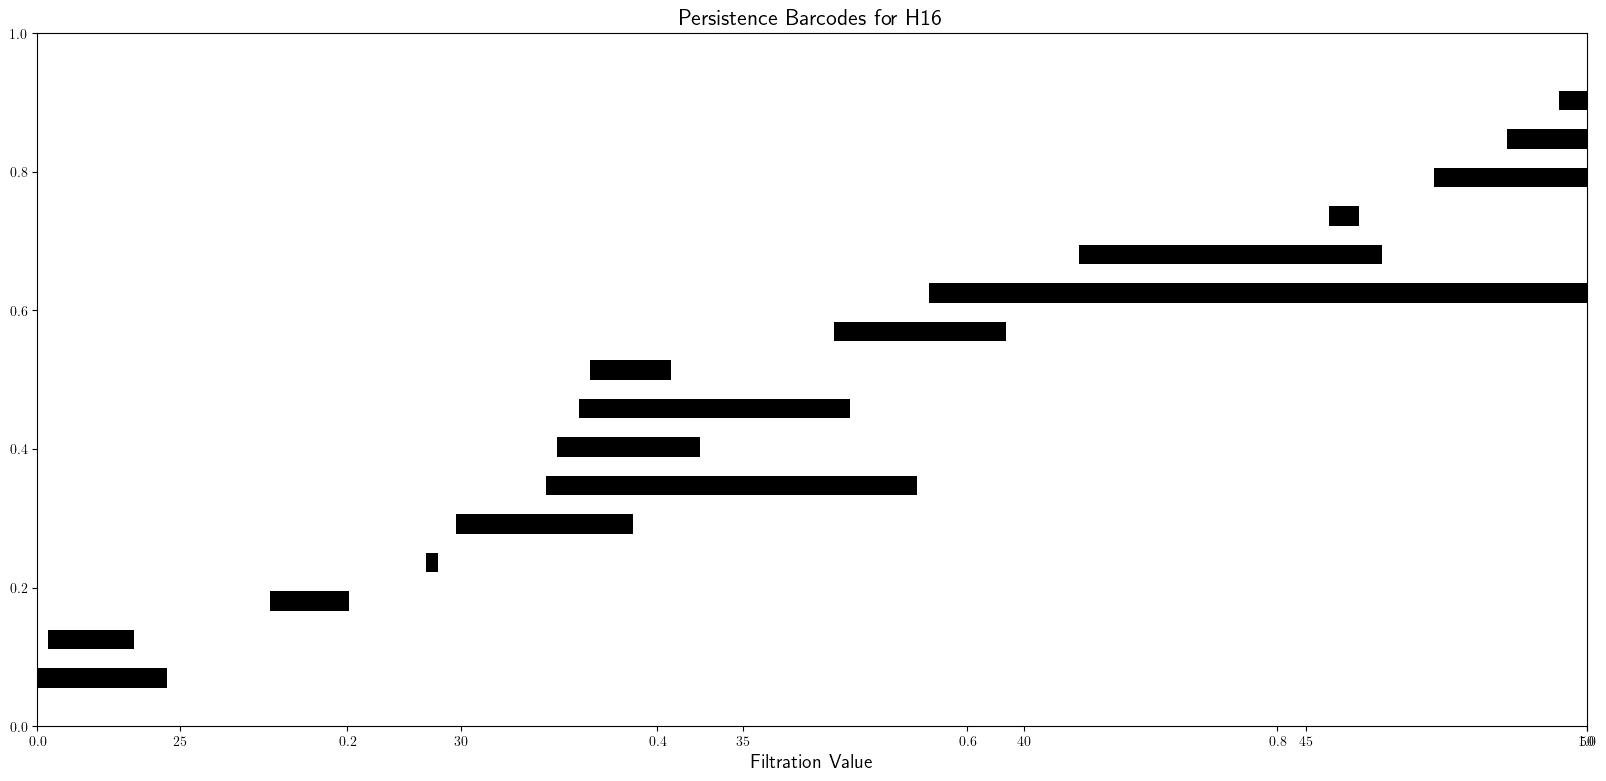

In [37]:
for it, PH in enumerate(MV_ss.persistent_homology):
    # Get minimum radius (birth) and set dimensions for plotting
    min_r = min(PH.barcode[:, 0])  # Births
    step = max_r / PH.dim  # Vertical step size for bar spacing
    width = step / 2.  # Width of each barcode

    # Initialize plot
    fig, ax = plt.subplots(figsize=(20, 9))
    ax = plt.axes(frameon=False)

    # Plot persistence barcodes
    y_coord = 0
    for b in PH.barcode:  # Iterate through each persistence interval
        ax.fill([b[0], b[1], b[1], b[0]],
                [y_coord, y_coord, y_coord + width, y_coord + width],
                'black')  # Use black for all bars
        y_coord += step  # Move to the next line for the next barcode

    # Customize plot
    ax.axes.get_yaxis().set_visible(False)  # Hide y-axis
    ax.set_xlim([min_r, max_r])  # Set x-axis limits
    ax.set_ylim([-step, y_coord + step])  # Set y-axis limits
    ax.set_title(f"Persistence Barcodes for H{PH.dim}", fontsize=16)
    ax.set_xlabel("Filtration Value", fontsize=14)

    # Save and display the plot
    plt.savefig(f"MV_barcode_dim{PH.dim}_r{it}.png")
    plt.show()
